In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https:

In [11]:
docs_df = pd.read_csv("../corpus/dev.docs", delimiter="\t", header=None, names=["docid", "text"])

Load the queries "xyz.titles.queries" and the groundtruth "xyz.2-1-0.qrel".

In [12]:
queries_df = pd.read_csv("../query/dev.titles.queries", delimiter="\t", header=None, names=["queryid", "text"])
relqueries_df = pd.read_csv("../qrel/dev.2-1-0.qrel", delimiter="\t", header=None, names=["queryid", "0", "docid", "rellvl"])

relqueries_df.loc[:, "rellvl"] = 1

In [13]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\pascal quindeau\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https:

In [21]:
merged_data = relqueries_df.merge(docs_df, on="docid").merge(queries_df, on="queryid", suffixes=["doc", "query"])
merged_data = merged_data[["textquery", "textdoc", "rellvl"]]
merged_data

,textquery,textdoc,rellvl
0,why deep fried foods may cause cancer,birth weight head circumference prenatal expos...,1
1,why deep fried foods may cause cancer,statistical regression model estimation acryla...,1
2,why deep fried foods may cause cancer,chronic intake potato chips humans increases p...,1
3,why deep fried foods may cause cancer,dietary patterns breast cancer risk women pubm...,1
4,why deep fried foods may cause cancer,empirically derived dietary patterns risk post...,1
...,...,...,...
11380,is kimchi good for you ?,bacterial vaginosis variation dietary indices ...,1
11381,is kimchi good for you ?,high fat intake leads acute postprandial expos...,1
11382,is kimchi good for you ?,capacity foodstuffs induce innate immune activ...,1
11383,is kimchi good for you ?,acute subacute toxicity tyramine spermidine sp...,1


In [79]:
def negSample(n):
    #q = "why deep fried foods may cause cancer"
    neg_df = pd.DataFrame(columns=["textquery", "textdoc", "rellvl"])
    for i, q in enumerate(queries_df["text"]):

        tmp = merged_data[~ (merged_data["textquery"] == q)]["textdoc"]
        neg_samples = np.random.choice(tmp, size=n, replace=False)
        #print(i)
        df = pd.DataFrame(data={"textquery": q,
                           "textdoc": neg_samples,
                           "rellvl":0})
        neg_df = neg_df.append(df).copy()
    
    return neg_df.reset_index(drop=True)

In [80]:
negdf = negSample(15)

In [90]:
train_data = merged_data.append(negdf)
train_data = train_data.sample(frac=1)
train_data

,textquery,textdoc,rellvl
10408,uterine cancer,flax breast cancer systematic review pubmed nc...,1
6518,steroids,physical activity obesity eating habits influe...,1
3454,anabolic steroids in meat,iodine thyroid cancer risk women multiethnic p...,0
3243,cinnamon for diabetes,cinnamon intake lowers fasting blood glucose m...,1
4528,world health organization,energy fructose beverages sweetened sugar high...,1
...,...,...,...
369,cookies,heterocyclic amines mutagens/carcinogens produ...,1
4245,apigen,antidiabetic potential commonly consumed legum...,0
2076,chemotherapy,concordance world cancer research fund/america...,1
2534,treating asthma and eczema with plant-based diets,plant foods risk cerebrovascular diseases pote...,0


In [86]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join("../models/bert_en_uncased_L-12_H-768_A-12_4/assets/", "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))


Vocab size: 30522


In [87]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [88]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [95]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

query = tf.ragged.constant([
     encode_sentence(s) for s in tf.convert_to_tensor(train_data["textquery"])])
sentence = tf.ragged.constant([
     encode_sentence(s) for s in tf.convert_to_tensor(train_data["textdoc"])])

In [96]:
print("Sentence1 shape:", query.shape.as_list())
print("Sentence2 shape:", sentence.shape.as_list())


Sentence1 shape: [16260, None]
Sentence2 shape: [16260, None]


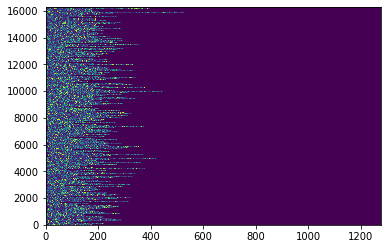

In [97]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*query.shape[0]
input_word_ids = tf.concat([cls, query, sentence], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

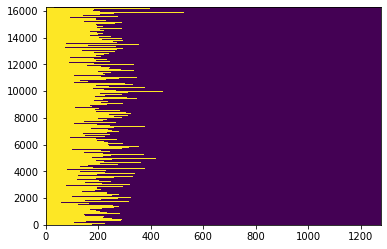

In [98]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

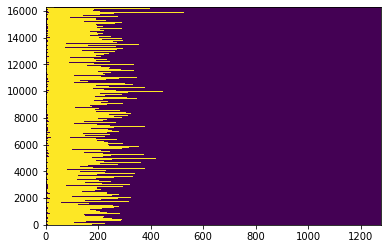

In [100]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(query)
type_s2 = tf.ones_like(sentence)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)


In [103]:
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
    num_examples = len(glue_dict["textquery"])

    sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["textquery"])])
    sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["textdoc"])])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [104]:
glue_train = bert_encode(train_data, tokenizer)
glue_train_labels = train_data['rellvl']

In [107]:
for key, value in glue_train.items():
    print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')


input_word_ids  shape: (16260, 1276)
input_mask      shape: (16260, 1276)
input_type_ids  shape: (16260, 1276)
glue_train_labels shape: (16260,)


In [26]:
preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")


text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string),
               tf.keras.layers.Input(shape=(), dtype=tf.string)]

tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

# Step 2 (optional): modify tokenized inputs.
pass

# Step 3: pack input sequences for the Transformer encoder.
seq_length = 512  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.

encoder_inputs = bert_pack_inputs(tokenized_inputs)


#input = preprocessor([["This is an amazing movie!"], ["Guten Tag!"]])

In [27]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)

In [28]:
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]

In [31]:
embedding_model = tf.keras.Model(text_inputs, pooled_output)
sentences1 = tf.constant(["your text here"])
sentences2 = tf.constant(["your text here again"])
print(embedding_model([sentences1, sentences2]))

tf.Tensor(
[[-0.98688966 -0.9089048  -0.99971193  0.99159765  0.984704   -0.81405705
   0.996529    0.82142717 -0.99922305 -1.         -0.9676708   0.9993619
   0.97088766  0.9816123   0.9844062  -0.986985   -0.9687135  -0.9018481
   0.80220646 -0.9646005   0.9425796   1.         -0.85206443  0.7913367
   0.93046665  0.9999957  -0.98084235  0.9646719   0.98235774  0.8040154
  -0.9815867   0.79421306 -0.9835208  -0.7857129  -0.9995796  -0.99816024
   0.9271016  -0.90763927 -0.7537526  -0.63823724 -0.9580901   0.87004083
   1.          0.9001473   0.8737939  -0.8261321  -1.          0.8190876
  -0.9465217   0.9998865   0.9992553   0.9993681   0.8404662   0.9233849
   0.92387635 -0.8552044   0.7521898   0.7830656  -0.7644097  -0.94173855
  -0.8937286   0.8930864  -0.99866444 -0.9753571   0.9997553   0.9989483
  -0.875799   -0.8205304  -0.8288699   0.6664066   0.9929852   0.80702084
  -0.7297061  -0.93260777  0.9974075   0.83782095 -0.9096185   1.
  -0.97376573 -0.98517245  0.99796855  0.9